In [145]:
class User:
    def __init__(self, name): 
        self.id = name
        self.advisors = [] #neighbors
        self.providers = []
        self.interactions = {}
        self.total_interactions = 0
        self.provider_raputation = {}
        self.advisor_reputation = {}
        self.decay = 1
        self.phi = 0.7
        self.epsilon = 0.001
        self.limit = 0 #tolarance limit
        self.satisfaction = {}
        self.disatisfaction = {}
            
    def interact(self, provider, rating):
        if provider.id != self.id:
            if provider in self.providers:
                ratelist = self.interactions[provider]
            else:
                ratelist = []
                self.providers.append(provider)

            ratelist.append(rating)
            self.interactions[provider] = ratelist
            self.total_interactions += 1

#             print("Consumer :"+str(self.id)+" rated Provider :"+str(provider.id)+" with "+str(rating))
            self.eval_provider(provider, rating)
        else:
            print('I cant interact with myself')
        
        
    def eval_provider(self, provider, rating):
        exp_val_n = len(self.interactions[provider])
        rj = ((1- rating) * self.phi) * (self.decay **(exp_val_n - self.limit)) #disatisfaction
        sj = ((1+ rating) * self.phi) * (self.decay **(exp_val_n - self.limit)) #satisfaction
        self.limit += 1
#         print("Consumer :"+str(self.id)+" evaluates Provider :"+str(provider.id)+" satisfaction: "+str(sj)+ "disatisfaction :"+str(rj))
        
        if provider in self.satisfaction:
            cumilative_satisfaction = self.satisfaction[provider]
            cumilative_disatisfaction = self.disatisfaction[provider]
            cumilative_satisfaction += sj
            cumilative_disatisfaction +=rj
        else:
            cumilative_satisfaction = sj
            cumilative_disatisfaction = rj
        self.satisfaction[provider] = cumilative_satisfaction
        self.disatisfaction[provider] = cumilative_disatisfaction
        
#         print("Consumer :"+str(self.id)+"'s current satisfaction and disatisfaction for Provider :"+str(provider.id)+" are : "+str(cumilative_satisfaction)+ " :"+str(cumilative_disatisfaction))
        self.get_belief(provider)
    
    def get_belief(self, provider):
            cum_sat = self.satisfaction[provider]
            cum_dis = self.disatisfaction[provider]
            total_sat_dit = cum_dis+cum_sat
            den = total_sat_dit + self.epsilon 
#             print(total_sat_dit)
            belief = cum_sat /(den)
            disbelief = cum_dis /(den)
            uncertainity = self.epsilon / (den)
            
#             print("Consumer :"+str(self.id)+"'s current belief,disbelief, and uncertainity for Provider :"+str(provider.id)+" are : "+str(belief)+ " :"+str(disbelief)+ " : "+str(uncertainity))
        
            return belief, disbelief, uncertainity
        
        
    def provider_raputation(self, provider):
        return provider_raputation[provider]
    
    def get_providers(self):
        return self.providers
        
    def get_similarity(self, advisor):
#         print('My providers are :'+str([x.id for x in self.get_providers()]))
#         print('Advisor providers are :'+str([x.id for x in advisor.get_providers()]))
        ishere = True if advisor in self.advisors else False
#         print('Advisor'+str(advisor.id)+' is in :'+str(ishere))
        
        if advisor in self.advisors:
            cum_dist = 0
            comm_vendors = 0
            similarity = 0
            for p in advisor.providers:
                if p in self.providers:
                    comm_vendors += 1
                    a_bel, a_disbel, a_unc = self.get_belief(p)
                    b_bel, b_disbel, b_unc = advisor.get_belief(p)
                    nonsqrt=((a_bel - b_bel)**2) + ((a_disbel - b_disbel)**2) + ((a_unc - b_unc)**2)
                    dist = nonsqrt** (1/2)
                    dist = dist/2
                    cum_dist += dist
            if comm_vendors > 0:
                meanormilsed_distance = cum_dist/comm_vendors
                similarity = 1 - meanormilsed_distance
#                 print("Consumer :"+str(self.id)+" similarity with advisor :"+str(advisor.id)+" is "+str(similarity)+", nmd is "+str(meanormilsed_distance))
            return similarity
            
    def get_honesty(self,initr = 0.00001,inits = 0.00001):
        cum_sat = 0;
        cum_dis = 0;
#         print(self)
        for p in self.providers:
#             print(p.satisfaction[self])
            cum_sat += p.satisfaction[self]
            cum_dis += p.disatisfaction[self]
        return (initr + cum_sat) / (initr + inits + cum_sat + cum_dis)
        
    def set_adivsors(self, neigbors):
        self.advisors = neigbors
    def add_an_adivsor(self, neigbor):
        self.advisors.append(neigbor)
    
    def get_id(self):
        self.id
    
    def bayes(self, provider, initr = 0.0001, inits = 0.00001):
        cum_sat = self.satisfaction[provider]
        cum_dis = self.disatisfaction[provider]
        return (initr + cum_sat) / (initr + inits + cum_sat + cum_dis)
    
    def reputation(self, provider, alpha=0.2):
        rep = 0
        hon = 0
        rep_count = 0
        hon_count = 0
        for a in provider.get_providers(): #cusotomers (advisor) who had interacted with producer
            ap_bel, _, _ = a.get_belief(provider)
            if a in self.advisors:
                sim = self.get_similarity(a)
                rep += (ap_bel * sim)
                rep_count += 1
            else:
                a_hon = a.get_honesty()
                hon += (ap_bel * a_hon)
                hon_count += 1
        
        reputation = 0
        if rep_count > 0:
            reputation = (alpha * rep)/rep_count

        if hon_count > 0:
            reputation += ((1 - alpha) * hon)/hon_count
        return reputation
    
    def init_trust(provider, beta=0.5, trust_propensity=0.5):
        rep = self.reputation(provider)
        return (beta * trust_propensity ) + ((1-beta) * rep)
    
    def trust_T(df,initT, beta=0.5):
        t = self.init_trust(provider)
        b, d, u = self.get_belief(provider)
        trust = b + (t * u)
        trust_dash = d + ((1 - t) * u)
#         print("Sum test ="+str(trust + trust_dash))
        return trust

class Consumer(User):
    def __init__(self, name ):
        User.__init__(self,name)
        

class Producer(User):
    def __init__(self, name):
        User.__init__(self,name)

In [146]:
import random

class Experiment:
    def __init__(self, scenario, nconsumer, nproducer, ntransactions, seed=100):
        self.scenario = scenario
        self.nconsumer = nconsumer
        self.nproducer = nproducer
        self.ntransactions = ntransactions
        self.nfaket = int(ntransactions/10)
        self.init_trans = ntransactions - self.nfaket
        self.consumers = {}
        self.producers = {}
        random.seed(seed)
        self.graphdata = []
        self.graphdata2 = []
        self.badmouthdata = []
        self.badmouthdata2 = []
        self.start()
        
        
    def start(self):
        consumers = {}
        producers = {}
        consumer_id_start_range = 100
        producer_id_start_range = 200
        for x in range(self.nconsumer):
            c = Consumer(consumer_id_start_range+x)
            consumers[c.id] = c
        for y in range(self.nproducer):
            p = Consumer(producer_id_start_range+y)
#             producers.append(p)
            producers[p.id] = p
#         print('experiment'+str(self.scenario)+' initialised with'+str(len(consumers))+" c and "+str(len(producers))+" p")
        self.consumers = consumers
        self.producers = producers
        
        targetc = consumers[103]
        targetp = producers[202]
        
#         for _,c in consumers.items():
#             for l in range(len(consumers)):
#                 if l%3 == 0:
#                     _, ad = random.choice(list(consumers.items()))
#                     if c != ad:
#                         c.add_an_adivsor(ad)
#                         ad.add_an_adivsor(c)
#                         c.interact(ad, random.uniform(0, 1))
#                         ad.interact(c, random.uniform(0, 1))
        
        for _,c in consumers.items():
            for i in range(self.init_trans):
#                 
                _, p = random.choice(list(producers.items()))
                c.interact(p, random.uniform(0, 1))
                p.interact(c, random.uniform(0, 1))
                if c == targetc and p == targetp:
                    self.graphdata.append(targetc.reputation(targetp))
                    self.graphdata2.append(targetc.bayes(targetp))
        

    def ballot_stuffing(self, providerid, consumerid, rating=0.9, targetc=103, n_consumers=1):
        p = self.producers[providerid]
        c = self.consumers[consumerid]
        c2 = self.consumers[consumerid+1]
        t = self.consumers[targetc]
        for x in range(self.nfaket):
            c.interact(p, rating)
            p.interact(c, rating)
            c2.interact(p, rating)
            p.interact(c2, rating)
            self.graphdata.append(t.reputation(p))
            self.graphdata2.append(t.bayes(p))
            
    def bad_mouthing(self, victim, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[victim]
        c = self.consumers[consumerid]
        c2 = self.consumers[consumerid+1]
        t = self.consumers[targetc]
        for x in range(self.nfaket):
            c.interact(p, rating)
            p.interact(c, random.uniform(0, 1))
            c2.interact(p, rating)
            p.interact(c2, random.uniform(0, 1))
            self.graphdata.append(t.reputation(p))
            self.graphdata2.append(t.bayes(p))
            
    def majority_descrimination(self, attacker, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[attacker]
        t = self.consumers[targetc]
        for _, c in self.consumers.items():
            if c != t:
                for x in range(self.nfaket):
                    if c.id <= 104:
                        c.interact(p, 1)
                        p.interact(c, 1)
                    else:
                        c.interact(p, random.uniform(0, 0.5))
                        p.interact(c, 0)
                    self.graphdata.append(t.reputation(p))
                    self.graphdata2.append(t.bayes(p))
                                   
    def minority_descrimination(self, attacker, consumerid, rating=0.001, targetc=103, n_consumers=1):
        p = self.producers[attacker]
        t = self.consumers[targetc]
        for _, c in self.consumers.items():
            if c != t:
                for x in range(self.nfaket):
                    if c.id <= 104:
                        c.interact(p, 0)
                        p.interact(c, 0)
                    else:
                        c.interact(p, random.uniform(0.5, 1))
                        p.interact(c, random.uniform(0.5, 1))
                    self.graphdata.append(t.reputation(p))
                    self.graphdata2.append(t.bayes(p))
        
    
    def plot(self):

        import matplotlib.pyplot as plt
        import numpy as np
        
#         print(self.graphdata)

        # Prepare the data
        x = np.linspace(0, len(self.graphdata), len(self.graphdata))

        # Plot the data
        plt.plot(x, self.graphdata2, alpha=0.7, label='Bayes')
        plt.plot(x, self.graphdata, alpha=0.7, label='ROBUSTRA')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()

In [147]:
scenario = 0
n_consumers = 20
n_producers = 10
n_transactions = 250
seed = 100

%matplotlib inline



Scenario :0


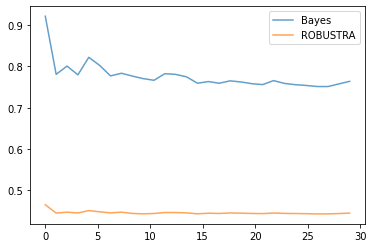

Scenario :1
Scenario :ballot_stuffing


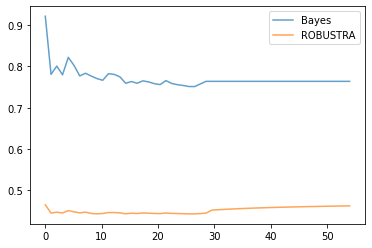

Scenario :2
Scenario :bad_mouthing


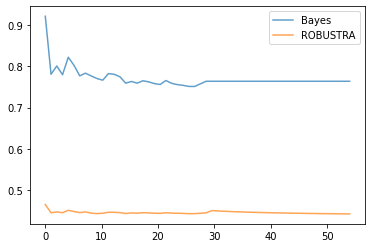

Scenario :3
Scenario :majority_descrimination


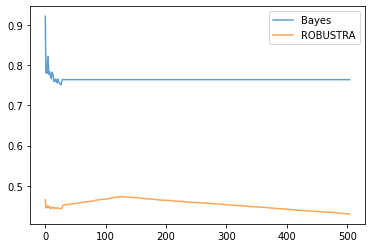

In [148]:
for xx in range(4):
    print('Scenario :'+str(xx))
    exp1 = Experiment(scenario, n_consumers, n_producers, n_transactions, seed)
    if xx == 1:
        print('Scenario :ballot_stuffing')
        exp1.ballot_stuffing(202, 101, 1, targetc=103, n_consumers=1)
    elif xx == 2:
        print('Scenario :bad_mouthing')
        exp1.bad_mouthing(202, 101, 0.001, targetc=103, n_consumers=1)
    elif xx == 3:
        print('Scenario :majority_descrimination')
        exp1.majority_descrimination(202, 101, 0.001, targetc=103, n_consumers=1)
    elif xx == 4:
        print('Scenario :minority_descrimination')
        exp1.minority_descrimination(202, 101, 0.001, targetc=103, n_consumers=1)
    
    exp1.plot()

    
    